# 0.0.Entendimento Do Problema de Negócio

- Objetivo do Problema
    - 1.0.Previsão do preço final para cada casa.
- Por que?
    - Qual o Tipo de modelo Negocio que estamos lidando?
        - Estamos lidando com um tipo de négocio de compra e venda de casas.
           - Comprar casas por um preço menor e vender por um preço mais caro
    - Como a empresa ganha dinheiro?(A grosso modo)
        - A empresa ganha dinheiro comprando casas por um preço menor e vendendo por um preço maior.
            - Receita: Venda - Compra = Receita.
            
- Contexto:
    - Possivelmente o problema aqui e a automação da precificação dos preços das casas, pois a empresa está querendo comprar mais imóveis e não sabe o preço que aquele imóvel deveria estar, e por esse motivo acaba deixando passar boas oportunidades de compra ou até comprando imóveis que estão com o preço além do que deveria estar.
           
- Proposta de Solução
    - 1.0.Para descobrir o preço justo da casa eu vou fazer um modelo preditivo que dada as caracteristicas nos de o preço do imóvel.
    - 2.0.Como o modelo vai ajudar a empresa a ganhar mais dinheiro?
        - O modelo vai ajudar na hora de comprar um imóvel, como ele vai nos trazer a precificação que aquele imóvel deveria estar, o comprador vai saber exatamente se está comprando um imóvel que está com o preço abaixo ou acima do que deveria estar, tendo essa informação em mãoes ele vai poder negociar de uma melhor forma a compra de um imóvel, afetando assim diretamente a Receita da empresa, pois ele vai saber as melhores oportunidades de compra, consequentemente comprando mais barato e no futuro vendendo mais caro, assim aumentando a Receita da empresa.
    - 2.0.Produto Final(O que eu vou entregar no fim do projeto)
       - WebApp
         - Input: Recebe as caracteristicas da casa
         - Output: Retorna o preço da casa.

# 1.0.Imports

In [1]:
#-------Libraries pattern----------------
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
#---------------------------------------

#------------------ProfileReport----------
from pandas_profiling import ProfileReport
#-----------------------------------------

#------------Machine Learning---------------------
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
#-------------------------------------------------

#------------------Random-------------------------
import random
#------------Data Preparation---------------------
from sklearn import preprocessing as pp
#-------------------------------------------------
#Show all columns
pd.set_option('display.max_columns', None)

#filter warnings
import warnings
warnings.filterwarnings('ignore')

## 1.1.Load Data

In [2]:
df_train = pd.read_csv('datasets/train.csv')
df_train.shape

(1460, 81)

## 1.2.Help Functions

In [3]:
def cross_validation(nome_modelo,model,num_folds,x_train,y_train,verbose=False):
    r2_list  = []
    rmse_list   = []
    mae_list    = []
    mape_list   = []
    
    #generate k-fold
    Kfold = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=32)
    
    i=1
    for train_ix, val_ix in  Kfold.split(X_train,y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i,num_folds))
        
        #get fold
        x_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]
        
        x_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        
        #Model train
        model.fit(x_train_fold,y_train_fold)

        #prediction
        pred_nn = model.predict(x_val_fold)


        #Metrics
        mae = mean_absolute_error(y_val_fold, pred_nn)
        mae_list.append(mae)

        mape = mean_absolute_percentage_error(y_val_fold,pred_nn)
        mape_list.append(mape)

        r2 = r2_score(y_val_fold,pred_nn)
        r2_list.append(r2)

        rmse = np.sqrt(mean_squared_error(y_val_fold,pred_nn))
        rmse_list.append(rmse)

        i+=1
    return pd.DataFrame({'Nome Modelo':nome_modelo,
                         'MAE CV':np.round(np.mean(mae_list),2).astype(str) +  ' +/- ' +np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV':np.round(np.mean(mape_list),2).astype(str) +  ' +/- ' +np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV':np.round(np.mean(rmse_list),2).astype(str) +  ' +/- ' +np.round(np.std(rmse_list),2).astype(str),
                         'R² CV':np.round(np.mean(r2_list),2).astype(str) +  ' +/- ' +np.round(np.std(r2_list),2).astype(str)},index=[0])
        
def avaliar_modelo(nome_modelo,y_test,previsao):
    mae = mean_absolute_error(y_test,previsao)
    mape = mean_absolute_percentage_error(y_test,previsao)
    r2 = r2_score(y_test,previsao)
    rmse = np.sqrt(mean_squared_error(y_test,previsao))

    return pd.DataFrame({'Model name':nome_modelo,
                         'MAE':'{:.2f}'.format(mae),
                         'MAPE':'{:.2%}'.format(mape),
                         'RMSE':'{:.2f}'.format(rmse),
                         'R²':'{:.2%}'.format(r2)},index=[0])


def show_dimensions(data):
    return print('Numbers of Rows: {}\nNumbers of Columns: {}'.format(data.shape[0],data.shape[1]))


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr= k - (k-1)**2/(n-1)
    rcorr= r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1) ))


#Função que vai criar um grafico com as features usadas pelo modelo

def Importancia_coluna(modelo,coluna):
    #Dados
    modelo_importances = pd.DataFrame(modelo.feature_importances_,coluna.columns)
    #Ordenando
    modelo_importances.sort_values(by=0,ascending=False,inplace=True)
    #Grafico
    grafico = plt.figure(figsize=(12,6))
    plt.xticks(rotation=90)
    sns.barplot(x= modelo_importances.index,y= modelo_importances[0])

# 2.0.Data Descripition

In [4]:
df1 = df_train.copy()
df1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2.1.Data Dimensions

In [5]:
show_dimensions(df1)

Numbers of Rows: 1460
Numbers of Columns: 81


## 2.2.Data Types

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 2.3.Change Data Type

In [7]:
#None to change

## 2.4.NA Check

**Colunas que serão deletadas:**
Colunas com 80 % ou mais de valores nulos serão deletadas, pelo motivo de estarem praticamente totalmente vazias e caso eu preencha elas com qualquer valor vou estar mudando o fenomeno que estou tentando prever.

In [8]:
aux = df1.isna().sum().reset_index().rename(columns={0:'NAN_Values','index':'Attributes'})
aux = aux[aux['NAN_Values'] > 0].sort_values(by='NAN_Values',ascending=False).reset_index(drop=True)
aux['% NA_Values'] = round(aux['NAN_Values'] / len(df1),2)
aux

,Attributes,NAN_Values,% NA_Values
0,PoolQC,1453,1.00
1,MiscFeature,1406,0.96
2,Alley,1369,0.94
3,Fence,1179,0.81
4,FireplaceQu,690,0.47
5,LotFrontage,259,0.18
6,GarageType,81,0.06
7,GarageYrBlt,81,0.06
8,GarageFinish,81,0.06
9,GarageQual,81,0.06


## 2.5.Substition Values NA

**Preenchimento de valores nulos:**
Vou escolher prencher os valores de LotFrontage e MasVnrArea com a médiana dos valores, pois depois de analisar a distribuição dessas variáveis percebi que havia uma concentração muito forte de valores entre 50 - 100 no caso da LotFrontage e na MasVnrArea o valor de zero é o que mais aparece, por isso vou escolher usar a Mediana, pois ele não sofre com valores outliers e é mais seguro em casos assim.

Já no caso da GarageYrBlt como e uma variavel de ano, eu vou escolher preencher os valores pela moda, pois em váriaveis de ano assim, não vejo problema em colocar o valor mais frequente.


**Removendo colunas e dropando valores NA das colunas categoricas:** Vou escolher remover a coluna categorica **FireplaceQu** pelo motivo de ser uma coluna categoria e possuir 690 valores categoricos faltantes, faço isso pois caso eu descida substituir o valor dessa coluna existe grande chances de eu inviezar o modelo, ou seja, fazer o modelo aprender aquilo que eu quero e não a realidade, por esse motivo vou escolher remover a coluna e as outras colunas colunas que são **Categoricas** vou escolher drop os valores.

In [9]:
cols_na = ['PoolQC','MiscFeature','Alley','Fence', #columns with NA values >= 80%
             'FireplaceQu' ] #column with 690 values categorical NA

In [10]:
#Drop columns with NA values
df1 = df1.drop(cols_na,axis=1)

#filling other columns numeric with the median
lot_median_value = df1['LotFrontage'].median()
df1['LotFrontage'] = df1['LotFrontage'].fillna(lot_median_value)

mas_vnr_area_median = df1['MasVnrArea'].median()
df1['MasVnrArea'] = df1['MasVnrArea'].fillna(mas_vnr_area_median)

garage_year_built_mode = df1['GarageYrBlt'].mode()[0]
df1['GarageYrBlt'] = df1['GarageYrBlt'].fillna(garage_year_built_mode)

#Drop NA values of categorical features
df1 = df1.dropna()

## 2.6.Description Analysis

In [11]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 2.6.1.Numerical Description

In [12]:
#Central Tendecy  - Mean - Median - Mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
ct3 = pd.DataFrame(num_attributes.apply(lambda x: x.mode()[0])).T

#Dispensions - STD - Min - Max - Range - Skew - Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
metrics = pd.concat([d2, d3, d4, ct1, ct2,ct3, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','mode','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,Id,1.0,1460.0,1459.0,731.228700,730.5,1.0,421.622046,0.000844,-1.196831
1,MSSubClass,20.0,190.0,170.0,56.136024,50.0,20.0,41.237158,1.391901,1.568995
2,LotFrontage,21.0,313.0,292.0,70.438714,69.0,69.0,22.162018,2.502469,22.864050
3,LotArea,1300.0,215245.0,213945.0,10706.294469,9600.0,9600.0,10332.757691,11.938124,191.844258
4,OverallQual,2.0,10.0,8.0,6.219731,6.0,6.0,1.323977,0.315218,-0.064293
5,OverallCond,2.0,9.0,7.0,5.596413,5.0,5.0,1.077721,0.897541,1.024759
6,YearBuilt,1880.0,2010.0,130.0,1973.029148,1976.0,2005.0,29.552490,-0.677966,-0.337735
7,YearRemodAdd,1950.0,2010.0,60.0,1985.668909,1994.5,1950.0,20.288877,-0.563345,-1.187460
8,MasVnrArea,0.0,1600.0,1600.0,110.360239,0.0,0.0,185.535444,2.582685,9.454536
9,BsmtFinSF1,0.0,5644.0,5644.0,464.234679,413.0,0.0,458.620941,1.693397,11.630118


### 2.6.2.Categorical Description

In [13]:
cat_attributes.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,14,16,4,4,4,5,4,4,4,6,6,4,5,2,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1066,1333,829,1206,1337,957,1265,209,1162,1324,1138,657,1037,1314,486,475,763,803,1183,620,594,1237,887,402,1176,1318,704,1277,1242,650,1254,852,580,1270,1287,1257,1158,1104


In [14]:
cat_attributes_list = cat_attributes.columns.tolist()
corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_ls = []
    for j in range(len(cat_attributes_list)):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]   
        
        #correlations
        corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
        
        #append list
        corr_ls.append(corr)
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_ls

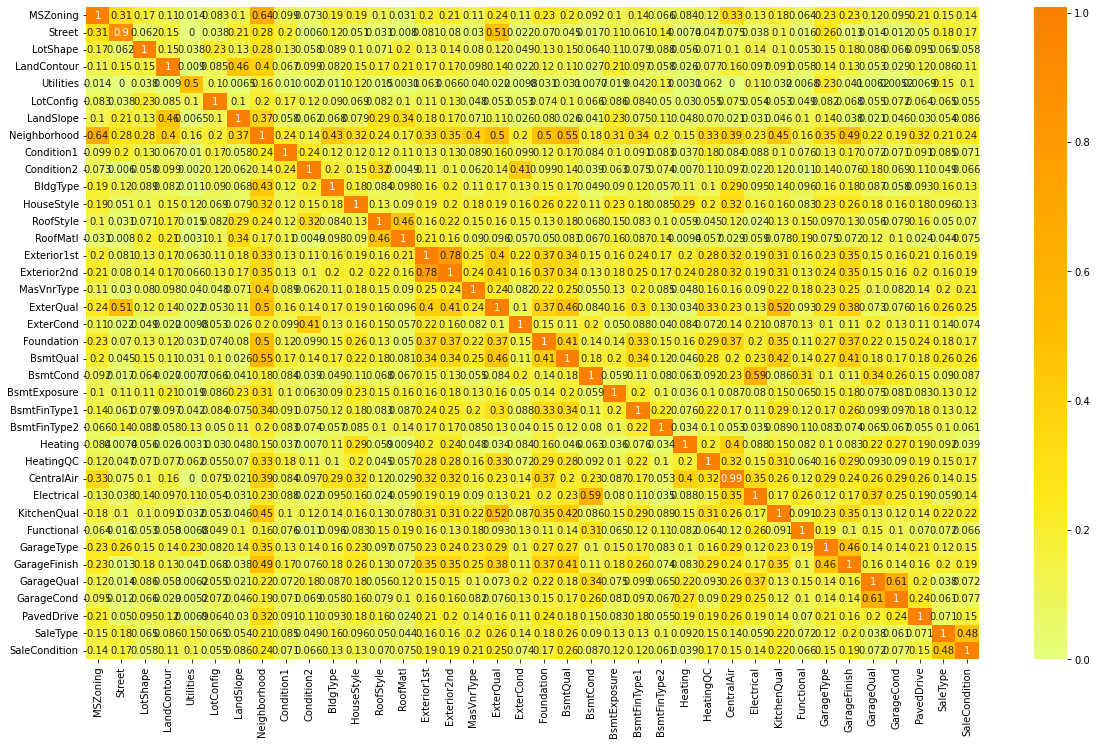

In [15]:
#Correlations to dataframe
categorical_corr = pd.DataFrame(corr_dict)
categorical_corr = categorical_corr.set_index(categorical_corr.columns)

#Show correlations
plt.figure(figsize=(20,12))
sns.heatmap(categorical_corr,cmap='Wistia',annot=True);

# 3.0.Feature Engienner

In [16]:
df2 = df1.copy()

In [17]:
df2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [18]:
df2.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

### Create news features

In [19]:
df2['size'] = df2['LotArea'].apply(lambda x: 'small' if x < 5000 else
                                             'medium' if x < 10000 else 'large')

df2['constrution'] = df2['YearBuilt'].apply(lambda x: '> 1960' if x > 1960 else '< 1960')

avg_properties = np.mean(df2['SalePrice'])
df2['below/above_average'] = df2['SalePrice'].apply(lambda x: 'below_avg' if x < avg_properties else 'above_avg') 

# 4.0.Data Filtering

In [20]:
df3 = df2.copy()

## 4.1.Filter Rows

**Filtrando valores de LotArea:**
Depois de fazer a análise descritiva dos dados, percebi que a variável LotArea estava com valores muito absurdos para o nosso objetivo, pois existiam imóveis com valores de até 2152,45 mil metros quadrados, sendo que a maior concentração dos dados não passa nem de 30 mil, por esse motivo e pelo fato de que estamos criando um modelo que consiga prever o preço de imóveis normais, 
que a empresa que comprar para revender logo, eu vou filtrar meus dados para pegar imóveis no range de 0 até 30 mil. 


**Filtrando valores de SalePrice:** Existem valores na SalePrice que estão na mesma situação que LotArea, por que aqui eu vou levar em conta o mesmo critério que usei para remover os valores de LotArea, pois relembrando objetivo que é criar um modelo que consiga precificar o preço de imóveis normais, pois o intuito e a compra e venda ou compra -> reforma -> venda dos imóveis, por isso eu vou escolher filtrar meus dados para pegar apenas os imóveis com valores abaixo de 400 mil, perdendo assim 24 informações.

In [21]:
df3 = df3[df3['LotArea'] < 30000]
df3 = df3[df3['SalePrice'] < 400000]

## 4.2.Filter Columns

In [22]:
#Drop columns with NA values
cols = ['MasVnrArea','BsmtFinSF2','2ndFlrSF','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
       'PoolArea','MiscVal','Condition2','Condition1','Street','Utilities','LandSlope','RoofMatl','Functional','KitchenAbvGr',
       'BsmtHalfBath','Electrical','CentralAir','Heating', #columns coming from EDA to remove
       'YearRemodAdd','GarageYrBlt','Exterior2nd','TotRmsAbvGrd','GarageCars','Neighborhood'] # high correlation
df3 = df3.drop(cols,axis=1)

In [23]:
show_dimensions(df3)

Numbers of Rows: 1293
Numbers of Columns: 50


# 5.0.Exploratory Data Analysis (EDA)

In [24]:
df4 = df3.copy()

## 5.1.Univariate Analysis

### 5.1.1.Reponse Variable

**Analise da distribuição:** Analisando o gráfico abaixo, posso notar que estamos lidando com uma distribuição positiva, que tem uma concentração maior no começo e uma cauda meio longa(Não tão longa pois já filtramos esses dados), e bom ver isso pois nos diz que a nossa variavel alvo não está tão dispersa assim, e na parte de Data-Preparation eu vou poder usar uma normalização para melhorar a perfomance do modelo e até deixa a distribuição normal, pois os modelos de machine learning funcionam melhor e esperam que os dados estejam em uma distribuição normal.

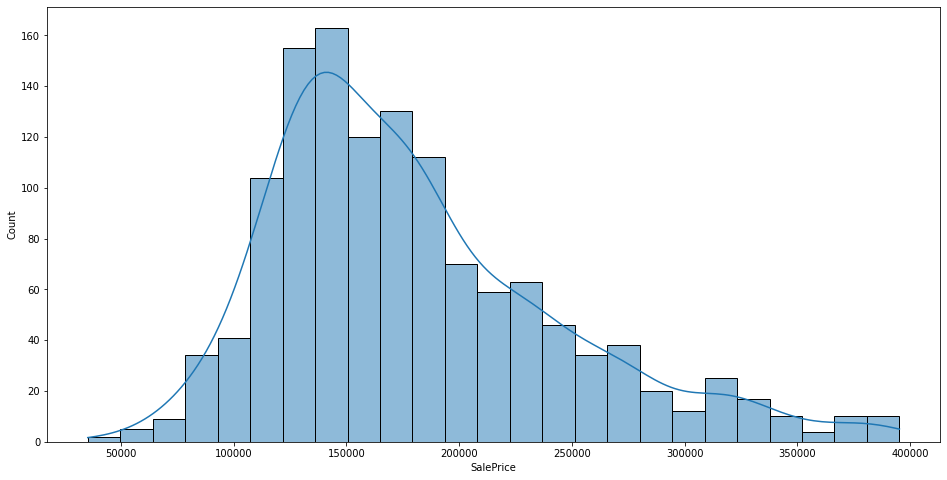

In [25]:
plt.figure(figsize=(16,8))
sns.histplot(df4['SalePrice'],kde=True);

### 5.1.2.Numerical Variables + Categorical Variables

In [26]:
#==============================Variáveis para remover depois da analise com pandas profiling================================
## Todas serão removidas na parte de Filtering, de modo que quando rodemos de novo o codigo, possamos ter o pandas profiling
### e o projeto, Mais limpo e assim nos permitendo analisar a correlação das variáveis.


#Esses html vã ser disponibilizando no Github, pasta: profiles_pandas.
#=================================================Variáveis com valores zero=============================================
## Variávies com valores de zero acima de 40% eu vou remover, pois não acho que variaveis assim sejam relevantes para o modelo
### de ML, pois o modelo precisa de padrões para aprender, e uma coluna cheia de zero não tem padrões para aprender,
#### por isso vou Escolher remover.

# MasVnrArea: 57,7% dos valores sendo 0

#BsmtFinSF2: 87,9% dos valores sendo zero

# 2ndFlrSF: 56,2% de valores sendo zero

#LowQualFinSF: 98,7% de valores sendo zero

#WoodDeckSF: 51,0% de valores sendo zero.

#OpenPorchSF: 43,6% de valores sendo zero.

#EnclosedPorch: 86,2% de valores sendo zero.

#3SsnPorch: 98,2% de valores sendo zero.

#ScreenPorch: 91,6% de valores sendo zero.

#PoolArea: 99,6% de valores sendo zero.

#MiscVal: 96,5% dos valores sendo zero.


#======================================Variáveis com valores muito desbalanceados=============================================
#Váriveis com muitos valores desbalanceados vão ser removidas, pelo mesmo critério de variaveis com muitos zeros, o modelo
## precisa de variedade para realmente aprender, e por esse motivo vou escolher remover as variáveis que eu achar que estão
### muito desbalanceadas, sendo meu critério de valores acima de 90%.

#Condition2: 99% dos valores sendo Norm

#Condition1: 86,8% dos valores sendo Norm

#Street: 99,8% sendo valores sendo pave

#Utilities: 99,9% dos valores sendo allpub

#LandSlope: 95,4% dos valroes sendo gtl

#RoofMatl: 98,7% dos valores sendo compshg

#Functional: 93,8% de valores sendo typ

#KitchenAbvGr: 97,0% dos valores sendo 1

#BsmtHalfBath: 94,0% dos valores sendo 0

#Electrical: 92,6% dos valores sendo sbrkr

#CentralAir: 95% dos valores sendo True

#Heating: 98% dos valores sendo gasa 

#======================================Variáveis com uma corelação muito forte=============================================

# Pode ser que já tenhamos tirados essas variaes com corelação forte, porém ainda vou olhar para confirma que variaveis que 
## forem muito corelacionas, ou seja, que falam da mesma coisa so que de uma forma diferente, não estejam no meu dataset,
### Vou deixa apenas 1 delas.


# -------------------Numerical------------------
#high correlation: Year Built  and YearRemodAdd
#keep: Year Built

#high correlation: GarageYrBlt and Year Built
#keep: Year Built

#-----------------Categorical-------------------
#high correlation: Exterior1st and Exterior2nd
#keep: Exterior1st

## 5.2.Bivariate Analysis

### **H1:** O crescimento de vendas YoY e de 10%.
**FALSA:** O crescimento YoY **não cresce** ao passar dos anos ele **DECAI**

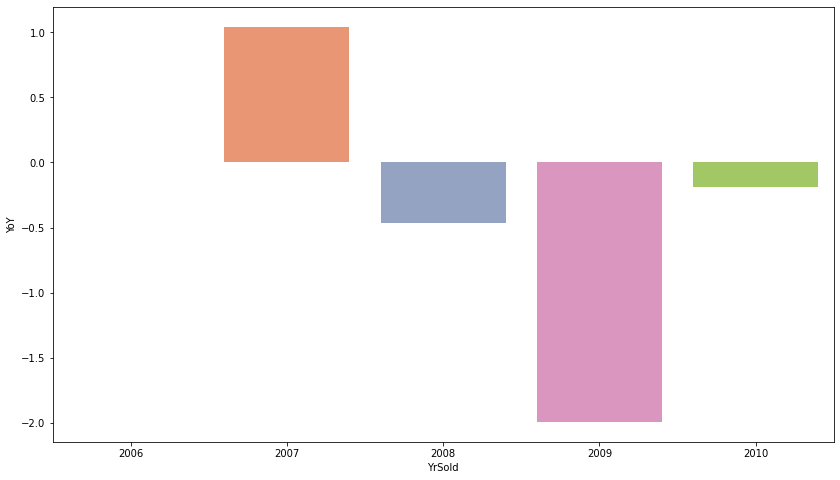

In [27]:
aux = df4[['SalePrice','YrSold']].groupby('YrSold').mean().reset_index()
aux['YoY'] = 100*aux['SalePrice'].pct_change().fillna(0)

plt.figure(figsize=(14,8))
sns.barplot(x='YrSold',y='YoY',data=aux,palette='Set2');

### **H2:** Imóveis com data de construção menor que 1960, são 40% mais baratos, na média.
**FALSA** Imoveis com data de contrução menor que 1960 são **41 % mais baratos na média**

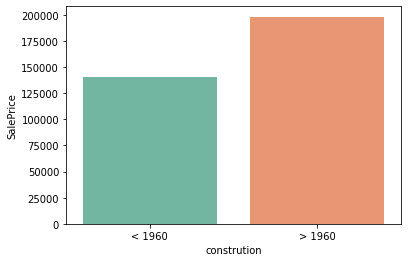

In [28]:
aux = df4[['SalePrice','constrution']].groupby('constrution').mean().reset_index()
aux['Diference %'] = round(100*aux['SalePrice'].pct_change().fillna(0),2)

sns.barplot(x='constrution',y='SalePrice',data=aux,palette='Set2');

In [29]:
aux

,constrution,SalePrice,Diference %
0,< 1960,140585.344578,0.00
1,> 1960,198232.648064,41.01


### **H3:** A região com mais imóveis possui o preço 10% maior do que as outras regiões, na média.
**FALSA:** Mesmo a região RL possuindo mais imóveis o preço médio dela e **12%** menor do que a região FV que possui menos imóveis.

In [30]:
aux = df4[['Id','MSZoning']].groupby('MSZoning').count().reset_index().rename(columns={'Id':'Qtd_Houses'}).sort_values(by='MSZoning')
aux1 = df4[['SalePrice','MSZoning']].groupby('MSZoning').mean().reset_index().sort_values(by='MSZoning')

#Merge datasets
aux3 = pd.merge(aux,aux1,how='left',on='MSZoning').sort_values(by='SalePrice',ascending=False)

#Diference 
aux3['Diference'] = round(100* aux3['SalePrice'].pct_change().fillna(0),2)

#Show results
aux3

,MSZoning,Qtd_Houses,SalePrice,Diference
1,FV,62,214888.129032,0.00
3,RL,1022,188284.281800,-12.38
4,RM,190,129601.415789,-31.17
2,RH,11,126539.454545,-2.36
0,C (all),8,78172.500000,-38.22


### **H4:** Imóveis com preço abaixo da média representam 45% ou mais da minhas vendas.
**VERDADEIRA:** Minhas vendas com os imóveis com preço abaixo da média **REPRESENTAM 76% DAS MINHAS VENDAS**

In [31]:
aux = df4[['Id','below/above_average']].groupby('below/above_average').count().reset_index().rename(columns={'Id':'Qtd_Imóveis'}).sort_values(by='Qtd_Imóveis',ascending=True)
aux['diference'] = round(100*aux['Qtd_Imóveis'].pct_change()).fillna(0)
aux

,below/above_average,Qtd_Imóveis,diference
0,above_avg,469,0.0
1,below_avg,824,76.0


### **H5:**O crescimento de vendas dos imóveis aumenta 10% a cada mes (MoM), na média.
**FALSA:** O crescimento a cada mes **não é de 10%** e tendem até a diminuir com o tempo, **com uma queda de 10% no mês 10**

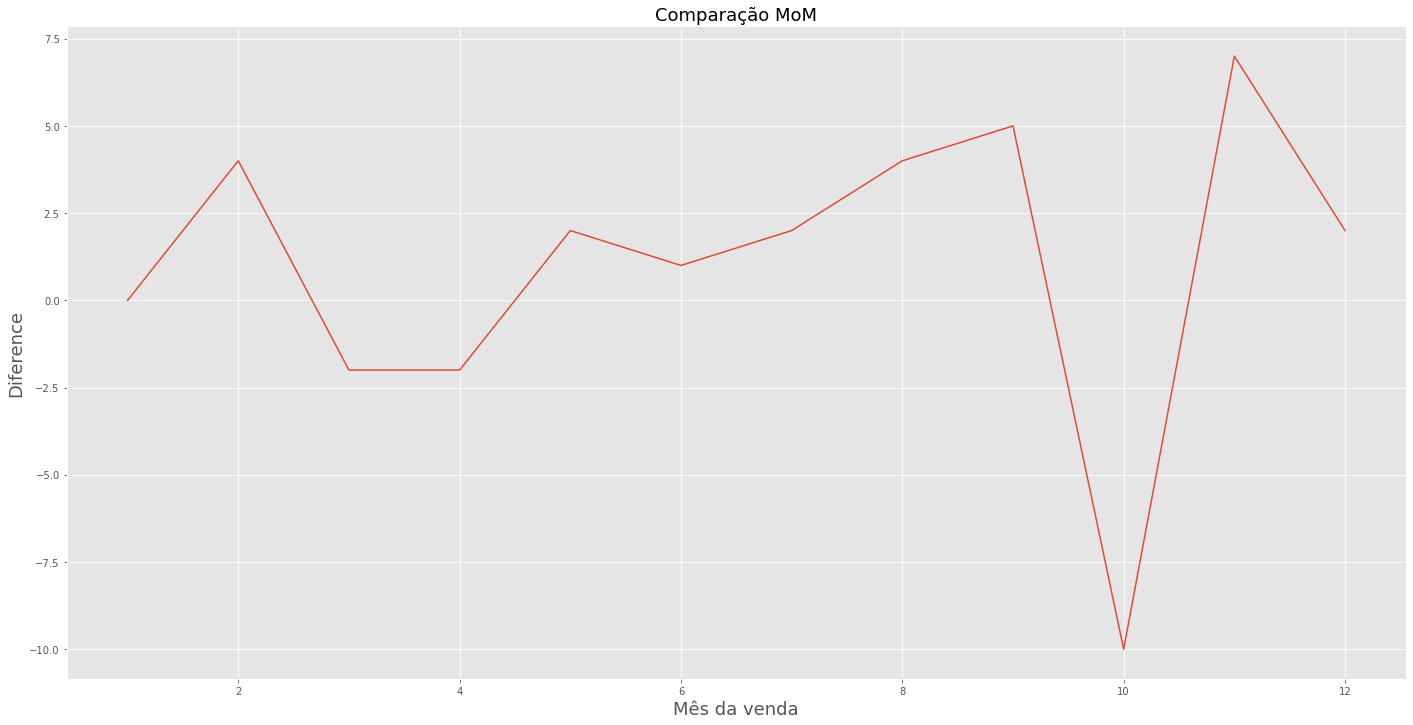

In [32]:
aux = df4[['SalePrice','MoSold']].groupby('MoSold').mean().reset_index().rename(columns={'SalePrice':'Avg_vendas'})
aux['Diference'] = round(100*aux['Avg_vendas'].pct_change()).fillna(0)
plt.figure(figsize=(24,12))
plt.style.use('ggplot')
sns.lineplot(x='MoSold',y='Diference',data=aux)
plt.title('Comparação MoM',fontsize=18)
plt.ylabel('Diference',fontsize=18)
plt.xlabel('Mês da venda',fontsize=18);

## 5.3.Multivariate analysis

In [33]:
numerical_data   = df4.select_dtypes(include=['int64','float64'])
categorical_data = df4.select_dtypes(exclude=['int64','float64']).drop(['size','constrution','below/above_average'],axis=1)

### 5.3.1.Numerical analysis

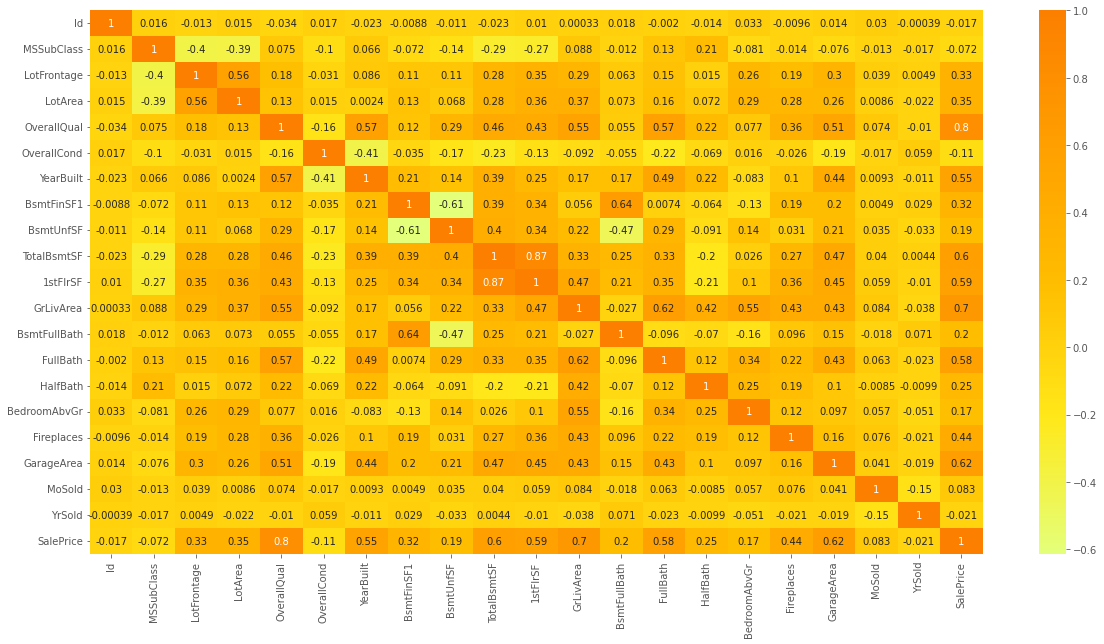

In [34]:
#-------------------------------Analisando as correlação--------------------------
## Aqui vou dar o ultimo check, para saber se estou levando para fase de Data-Preparation, somente as colunas mais importantes
###Claro que ainda vamos ter a fase de Feature_Selection mas como ela demora muito, o bom e so levar as variaveis mais importantes.

#-------------Váriaveis com uma correlação muito forte-------
# TotRmsAbvGrd - GrLivArea - correlação: 82%
# keep: GrLivArea
# remove: TotRmsAbvGrd
#reason: Vou manter ela pelo fato de parecer ter mais informação, acredito que o modelo vá aprender mais com ela
## mas aqui estou em dúvida, então o bom seria testa a perfomance do modelo sem ela (GrLivArea) e com ela. 

#GarageArea - GarageCars - correlação: 83%
#keep: GarageArea
#remove: GarageCars
#reason: Mesmo motivo da váriavel acima, acho que a GarageArea tem mais informação que a GarageCars

plt.figure(figsize=(20,10))
sns.heatmap(numerical_data.corr(),cmap='Wistia',annot=True);

### 5.3.2.Categorical Analysis

In [35]:
cat_attributes_list = categorical_data.columns.tolist()
corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_ls = []
    for j in range(len(cat_attributes_list)):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]   
        
        #correlations
        corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
        
        #append list
        corr_ls.append(corr)
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_ls

In [36]:
categorical_data.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

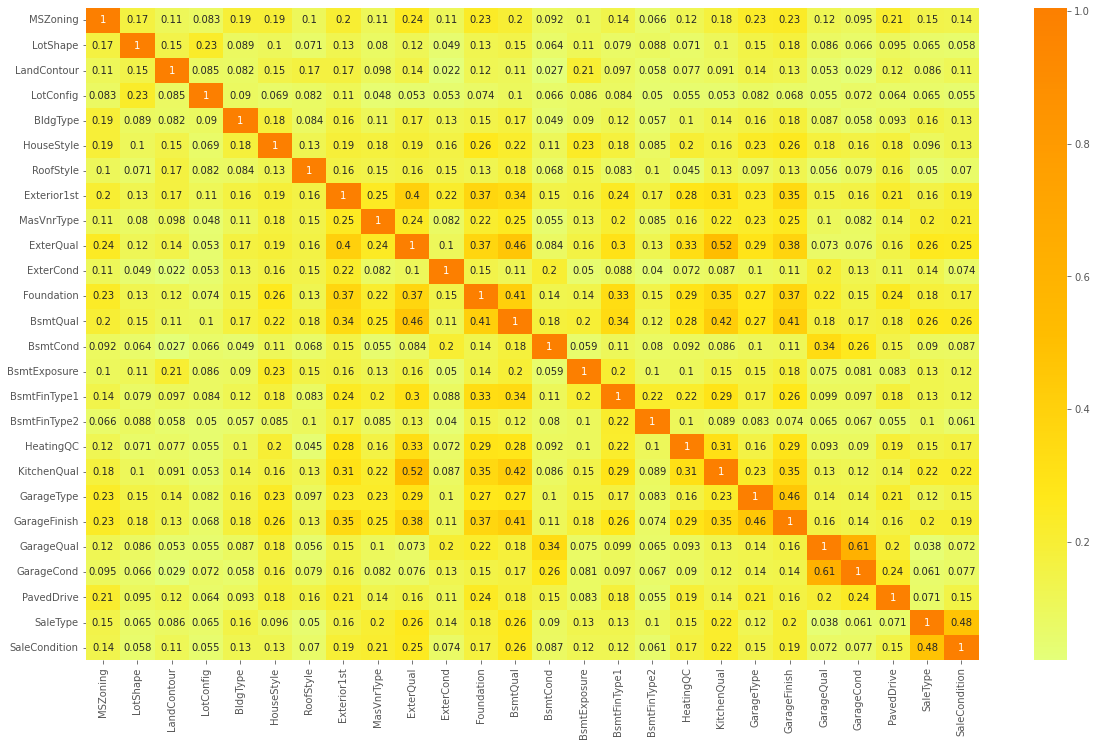

In [37]:
# -----------------------------------Analisando as correlações com dados Limpos.---------------------------------------------
#Aqui podemos ver uma melhora significativa em comparação com o que fizemos na fase de análise descritiva dos dados.

#--------Varíavel com correlação muito forte------

#MSZoning - Neighborhood: Correlação: 64%
#keep: MSZoning
#remove: Neighborhood
#reason: Vou escolher manter a MSZoning, pelo motivo dela com 4 valores representar 25 valores de Neighborhood, isso pensando
##na fase de data_preparation, pois fazer o enconder de variavel com muitos valores distintos não é tão simples, entaõ eu vou remover.





#Correlations to dataframe
categorical_corr = pd.DataFrame(corr_dict)
categorical_corr = categorical_corr.set_index(categorical_corr.columns)

#Show correlations
plt.figure(figsize=(20,12))
sns.heatmap(categorical_corr,cmap='Wistia',annot=True);

# 6.0.Data Preparation

In [38]:
#Removendo coluna que usei para responder as hipóteses de négocio
cols_rem = ['size','constrution','below/above_average']
df5 = df4.copy().drop(cols_rem,axis=1)

## 6.1.Normalization

In [39]:
ss  =  pp.StandardScaler()

In [40]:
#---------------------Distribuições proximas da normal, então vou usar: StandardScaler------------------------------------
#OverallQual
df5['OverallQual'] = ss.fit_transform(df5[['OverallQual']].values)

#OverallCond
df5['OverallCond'] = ss.fit_transform(df5[['OverallCond']].values)

#TotalBsmtSF
df5['TotalBsmtSF'] = ss.fit_transform(df5[['TotalBsmtSF']].values)

## 6.2.Rescaling

In [41]:
ss  =  pp.StandardScaler() 
rs  =  pp.RobustScaler()
mms =  pp.MinMaxScaler()

In [42]:
#-----------------------------MinMaxScaler and Robust Scaler--------------------------------

## ------------------------------MinMaxScaler-----------------------------------------
### Vou usar o MinMaxSclaer quando os dados estivem com uma distribuição mais uniforme.

#LotArea
df5['LotArea'] = mms.fit_transform(df5[['LotArea']].values)

#BsmtUnfSF - Como os dados não estão em uma distribuição normal e os dados não estão tao dispersos, vou usar: MinMaxScaler
df5['BsmtUnfSF'] = mms.fit_transform(df5[['BsmtUnfSF']].values)

#1stFlrSF - Como os dados não estão em uma distribuição normal e os dados não estão tao dispersos, vou usar: MinMaxScaler
df5['1stFlrSF'] = mms.fit_transform(df5[['1stFlrSF']].values)

#GrLivArea - Como os dados não estão em uma distribuição normal e os dados não estão tao dispersos, vou usar: MinMaxScaler
df5['GrLivArea'] = mms.fit_transform(df5[['GrLivArea']].values)

#YrSold - Como as informações são de ano, vou usar: MinMaxScaler
df5['YrSold'] = mms.fit_transform(df5[['YrSold']].values)

#YearBuilt - Como as informações são de ano, vou usar: MinMaxScaler
df5['YearBuilt'] = mms.fit_transform(df5[['YearBuilt']].values)


## ------------------------------Robust Scaler-----------------------------------------
### Vou usar quando estiver lidando com dados menos distribuidos, ou seja, que estejam focados em um valor espécifico, já que
#### o robust Scaler lida melhor com dados assim, diferente do MinMaxScaler.

#MSSubClass
df5['MSSubClass'] = rs.fit_transform(df5[['MSSubClass']].values)

#LotFrontage
df5['LotFrontage'] = ss.fit_transform(df5[['LotFrontage']].values)

#BsmtFinSF1
df5['BsmtFinSF1'] = rs.fit_transform(df5[['BsmtFinSF1']].values)

#BsmtFullBath
df5['BsmtFullBath'] = rs.fit_transform(df5[['BsmtFullBath']].values)

#FullBath
df5['FullBath'] = rs.fit_transform(df5[['FullBath']].values)

#HalfBath
df5['HalfBath'] = rs.fit_transform(df5[['HalfBath']].values)

#BedroomAbvGr
df5['BedroomAbvGr'] = ss.fit_transform(df5[['BedroomAbvGr']].values)

#Fireplaces
df5['Fireplaces'] = rs.fit_transform(df5[['Fireplaces']].values)

#GarageArea
df5['GarageArea'] = rs.fit_transform(df5[['GarageArea']].values)

## 6.3.Enconding

In [43]:
from category_encoders import CountEncoder

In [44]:
fq = CountEncoder()

In [45]:
#--------------------------Ordinal Encoder------------------------------------
# Existem valores que possuem uma certa hierarquia sobre o outros, por esse motivo resolvi usar esse metodo para respeita essa
## hierarquia de valores.

#LotShape - Ordinal Encoder
LotShape_dict = {'IR3':1,'IR2':2,'IR1':3,'Reg':4}
df5['LotShape'] = df5['LotShape'].map(LotShape_dict)

#ExterCond - Ordinal Encoder

ExterCond_dict = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
df5['ExterCond'] = df5['ExterCond'].map(ExterCond_dict)

#GarageQual - Ordinal Encoder
GarageQual_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df5['GarageQual'] = df5['GarageQual'].map(GarageQual_dict)

#BsmtQual - Ordinal Encoder
GarageCond_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df5['GarageCond'] = df5['GarageCond'].map(GarageCond_dict)

#ExterQual - Ordinal Encoder
ExterQual_dict = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
df5['ExterQual'] = df5['ExterQual'].map(ExterQual_dict)

#BsmtQual - Ordinal Encoder
BsmtQual_dict = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
df5['BsmtQual'] = df5['BsmtQual'].map(BsmtQual_dict)

#BsmtCond - Ordinal Encoder
BsmtCond_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4}
df5['BsmtCond'] = df5['BsmtCond'].map(BsmtCond_dict)

#BsmtExposure - Ordinal Encoder
BsmtExposure_dict = {'NA':1,'No':2,'Mn':3,'Av':4,'Gd':5}
df5['BsmtExposure'] = df5['BsmtExposure'].map(BsmtExposure_dict)

#BsmtFinType1 - Oridnal Encoder
BsmtFinType1_dict = {'NA':1,'Unf':2,'LwQ':3,'Rec':4,'BLQ':5,'ALQ':6,'GLQ':7}
df5['BsmtFinType1'] = df5['BsmtFinType1'].map(BsmtFinType1_dict)

#BsmtFinType2 - Ordinal Encoder
BsmtFinType2_dict = {'NA':1,'Unf':2,'LwQ':3,'Rec':4,'BLQ':5,'ALQ':6,'GLQ':7}
df5['BsmtFinType2'] = df5['BsmtFinType2'].map(BsmtFinType2_dict)

#HeatingQC - Ordinal Encoder
HeatingQC_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df5['HeatingQC'] = df5['HeatingQC'].map(HeatingQC_dict)

#KitchenQual - Ordinal Encoder
KitchenQual_dict = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
df5['KitchenQual'] = df5['KitchenQual'].map(KitchenQual_dict)

#--------------------------COUNT FREQUENCY------------------------------------
# Encondei todas abaixo , pelo motivo de que sempre existia um valor predominante, que se destacatava muito perando os outros,
## por isso achei melhor encondar todos com o COUNT Frequency, para manter essas variaveis com mais amostras predominante.


#MSZoning - CountEncoder
df5['MSZoning'] = fq.fit_transform(df5['MSZoning'])

#LandContour - CountEncoder
df5['LandContour'] = fq.fit_transform(df5['LandContour'])

#LotConfig - CountEncoder
df5['LotConfig'] = fq.fit_transform(df5['LotConfig'])

#BldgType - CountEncoder
df5['BldgType'] = fq.fit_transform(df5['BldgType'])

#RoofStyle - CountEncoder
df5['RoofStyle'] = fq.fit_transform(df5['RoofStyle'])

#GarageType - CountEncoder
df5['GarageType'] = fq.fit_transform(df5['GarageType'])

#SaleType - CountEncoder
df5['SaleType'] = fq.fit_transform(df5['SaleType'])

#SaleCondition - CountEncoder
df5['SaleCondition'] = fq.fit_transform(df5['SaleCondition'])

#--------------------------One Hot Encoder------------------------------------
# Aqui eu encondei por esse método pelo fato de que havia uma maior distribuição nos valores das variaveis abaixo, por isso 
## acredito que o modelo vai obter um maior benefício se eu encondar elas dessa forma.

#HouseStyle
df5 = pd.get_dummies(df5,prefix=['HouseStyle'],columns=['HouseStyle'])

#Exterior1st
df5 = pd.get_dummies(df5,prefix=['Exterior1st'],columns=['Exterior1st']) 

#MasVnrType
df5 = pd.get_dummies(df5,prefix=['MasVnrType'],columns=['MasVnrType']) 

#Foundation
df5 = pd.get_dummies(df5,prefix=['Foundation'],columns=['Foundation'])

#PavedDrive
df5 = pd.get_dummies(df5,prefix=['PavedDrive'],columns=['PavedDrive'])

#PavedDrive
df5 = pd.get_dummies(df5,prefix=['GarageFinish'],columns=['GarageFinish'])

## 6.4.Transformation

### 6.4.1.Nature Transformation

In [46]:
df5['month_sen'] = df5['MoSold'].apply(lambda x: np.sin(x * (2.*np.pi/12)))
df5['month_cos'] = df5['MoSold'].apply(lambda x: np.cos(x * (2.*np.pi/12)))

In [47]:
#Excluindo colunas:
#MoSold - Pois já que criei o Seno e Cosseno dela.
#Id - Pois não vai servir para fase de Machine Learning.
df5 = df5.drop(['MoSold','Id'],axis=1)

In [48]:
show_dimensions(df5)

Numbers of Rows: 1293
Numbers of Columns: 78


# 7.0.Feature Selection

In [49]:
df6 = df5.copy()

In [50]:
#Separando entre X e y para fazer o feature selection
X = df6.drop('SalePrice',axis=1)
y = df6['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)

In [51]:
#Treinando o modelo
rf = RandomForestRegressor(random_state=32)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=32)

**Análise:** Abaixo podemos ver o gráfico que representa a importancia de cada coluna para o modelo, e percebe que muitas colunas não são relevantes para o modelo, muitas mesmo pois depois das primeiras 10/15 ali práticamente não tem valor nenhum, por isso o Feature Selection é tão útil, pois sabemos agora que com 10/15 features podemos ter o mesmo resultado(ou até melhor) do que um dataset com mais 70 features.

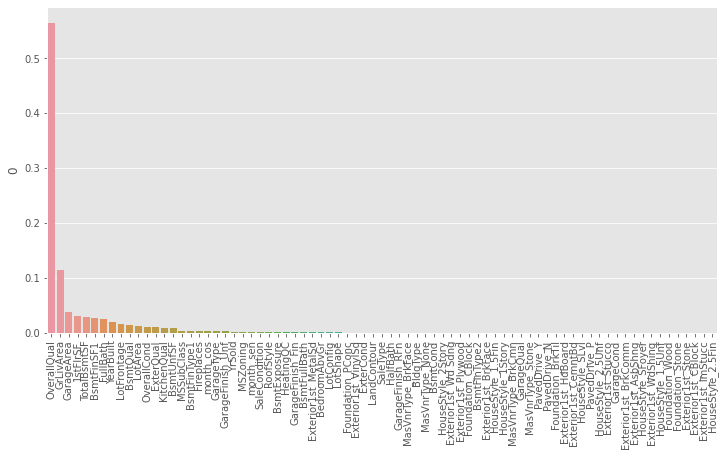

In [52]:
#Feature importances
Importancia_coluna(rf,X_train)

In [53]:
#Retornando as 13 features mais importantes
cols_selected = pd.DataFrame(rf.feature_importances_,X_train.columns).sort_values(by=0,ascending=False).head(13).index.tolist()
#Add SalePrice
cols_selected.extend(['SalePrice'])
cols_selected

['OverallQual',
 'GrLivArea',
 'GarageArea',
 '1stFlrSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'FullBath',
 'YearBuilt',
 'LotFrontage',
 'BsmtQual',
 'LotArea',
 'OverallCond',
 'ExterQual',
 'SalePrice']

# 8.0.Machine Learning Model

In [54]:
df7 = df6[cols_selected].copy()

In [55]:
df7.head()

,OverallQual,GrLivArea,GarageArea,1stFlrSF,TotalBsmtSF,BsmtFinSF1,FullBath,YearBuilt,LotFrontage,BsmtQual,LotArea,OverallCond,ExterQual,SalePrice
0,0.668843,0.416367,0.311321,0.169919,-0.604863,0.433428,0.0,0.946154,-0.227970,3,0.249485,-0.560597,3,208500
1,-0.126023,0.269722,-0.103774,0.334959,0.551663,0.818697,0.0,0.738462,0.502128,3,0.289612,2.213071,2,181500
2,0.668843,0.441244,0.594340,0.195935,-0.422554,0.121813,0.0,0.930769,-0.081950,3,0.347186,-0.560597,3,223500
3,0.668843,0.418658,0.754717,0.212602,-0.889722,-0.260623,-1.0,0.269231,-0.471336,2,0.287868,-0.560597,2,140000
4,1.463708,0.576105,1.669811,0.287398,0.218378,0.361190,0.0,0.923077,0.696821,3,0.452214,-0.560597,3,250000


In [56]:
X = df7.drop('SalePrice',axis=1)
y = df7['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)

In [57]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((905, 13), (388, 13), (905,), (388,))

## 8.1.BaseLine - Linear Model

### Linear Model

In [58]:
ln = LinearRegression()
ln.fit(X_train,y_train)
previsao_bn = ln.predict(X_test)

### Liner Model - Cross Validation

In [59]:
ln_cross = LinearRegression()
ln_result_cross = cross_validation('Linear Model',ln_cross,5,X_train,y_train)

## 8.2.Random Forest

### Random Forest

In [60]:
rf = RandomForestRegressor(random_state=32)
rf.fit(X_train,y_train)
previsao_rf = rf.predict(X_test)

### Random Forest - Cross Validation

In [61]:
rf_cross = RandomForestRegressor()
rf_result_cross = cross_validation('Random Forest',rf_cross,5,X_train,y_train)

## 8.3.Linear Regression Regularized Model - Lasso

### 8.3.1.Lasso

In [62]:
lrr = Lasso(alpha=0.01)

#Training model
lrr.fit(X_train,y_train)

#Prediction
previsao_lrr = lrr.predict(X_test)

### 8.3.2.Lasso - Cross Validation

In [63]:
lrr_cross = Lasso(alpha=0.01)

#Training Model with cross
lrr_result_cross = cross_validation('Lasso',lrr_cross,5,X_train,y_train)

## 8.4.ExtraTreesRegressor

### 8.4.1.ExtraTreesRegressor

In [64]:
ex = ExtraTreesRegressor(random_state=32)

#Traning Model
ex.fit(X_train,y_train)

#Predict
previsao_ex = ex.predict(X_test)

### 8.4.2.ExtraTreesRegressor - Cross Validation

In [65]:
ex_cross = ExtraTreesRegressor(random_state=32)
extra_tress_result_cross = cross_validation('ExtraTreesRegressor',ex_cross,5,X_train,y_train)

# 9.0. Perfomance

## 9.1.Simple perfomance

In [66]:
#Test Perfomance -BaseLine
baseline_result = avaliar_modelo('BaseLine - Linear Model',y_test,previsao_bn)

#Test Perfomance - Random Forest
rf_result = avaliar_modelo('Random Forest Regression',y_test,previsao_rf)

#Test Perfomance - Lasso
lasso_result = avaliar_modelo('Lasso',y_test,previsao_lrr)

#Test Perfomance - ExtraTreesRegressor
extra_trees_result = avaliar_modelo('ExtraTreesRegressor',y_test,previsao_ex)

#transform in dataframe
modeling_result = pd.concat([baseline_result,rf_result,lasso_result,extra_trees_result])
modeling_result.sort_values('RMSE')

,Model name,MAE,MAPE,RMSE,R²
0,ExtraTreesRegressor,15718.39,8.93%,22855.25,86.97%
0,BaseLine - Linear Model,17209.08,9.96%,22970.02,86.84%
0,Lasso,17209.09,9.96%,22970.04,86.84%
0,Random Forest Regression,15926.06,9.07%,22980.61,86.83%


## 9.2.Real Perfomance - Cross Validation

In [67]:
modeling_result_real = pd.concat([ln_result_cross,rf_result_cross,lrr_result_cross,extra_tress_result_cross]) 
modeling_result_real.sort_values('RMSE CV')

,Nome Modelo,MAE CV,MAPE CV,RMSE CV,R² CV
0,ExtraTreesRegressor,16112.7 +/- 1702.33,0.1 +/- 0.01,23024.63 +/- 2646.29,0.87 +/- 0.02
0,Random Forest,16585.33 +/- 1658.96,0.1 +/- 0.01,23513.5 +/- 2440.15,0.87 +/- 0.02
0,Linear Model,17369.08 +/- 1520.79,0.11 +/- 0.01,24027.83 +/- 2594.94,0.86 +/- 0.02
0,Lasso,17369.09 +/- 1520.8,0.11 +/- 0.01,24027.83 +/- 2594.94,0.86 +/- 0.02


# 10.0.Hyperparameter Fine Tuning
**Escolha do Modelo e Motivo:**

- Modelo Escolhido:ExtraTreesRegressor
- Motivo: Foi o campeão em perfomance e por se tratar de um modelo de decisão acredito que vai ser mais preciso em produção, por isso escolhi ele.

## 10.1.Extra Trees Regressor

In [68]:
params = {
    'n_estimators': [int(x) for x in np.linspace(start=1,stop=3000,num=10)],
    'max_depth':[int(x) for x in np.linspace(start=1,stop=30,num=5)],
    'min_samples_split':[2,5,10,12],
    'min_samples_leaf':[2,5,10,12],
    'max_features':['auto','sqrt'],
    'ccp_alpha':[0.0185,0.0190,0.0195,0.0200],
}
max_val = 10

In [69]:
final_result = pd.DataFrame()
for i in range(max_val):
    #choose values from parameters randomly
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    print(hp)
    #Model
    extra_trees_hp = ExtraTreesRegressor(
        n_estimators=hp['n_estimators'],
        max_depth=hp['max_depth'],
        min_samples_split=hp['min_samples_leaf'],
        max_features=hp['max_features'],
        ccp_alpha=hp['ccp_alpha'])
    
    result_hp = cross_validation('Random Forest Regressor',extra_trees_hp,5,X_train,y_train)
    final_result = pd.concat([final_result,result_hp])
final_result

{'n_estimators': 2666, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'auto', 'ccp_alpha': 0.019}
{'n_estimators': 1000, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'ccp_alpha': 0.019}
{'n_estimators': 1333, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'ccp_alpha': 0.019}
{'n_estimators': 2333, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'ccp_alpha': 0.02}
{'n_estimators': 667, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'ccp_alpha': 0.019}
{'n_estimators': 2333, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'ccp_alpha': 0.019}
{'n_estimators': 2333, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'ccp_alpha': 0.0185}
{'n_estimators': 2000, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_lea

,Nome Modelo,MAE CV,MAPE CV,RMSE CV,R² CV
0,Random Forest Regressor,16989.4 +/- 1709.16,0.1 +/- 0.01,24034.2 +/- 2535.08,0.86 +/- 0.02
0,Random Forest Regressor,18522.45 +/- 1624.14,0.12 +/- 0.01,26154.9 +/- 2729.07,0.84 +/- 0.03
0,Random Forest Regressor,15982.12 +/- 1697.19,0.1 +/- 0.01,22877.67 +/- 2889.02,0.87 +/- 0.03
0,Random Forest Regressor,16010.97 +/- 1692.07,0.1 +/- 0.01,22843.59 +/- 2597.6,0.88 +/- 0.02
0,Random Forest Regressor,16869.62 +/- 1653.35,0.1 +/- 0.01,24219.88 +/- 2822.8,0.86 +/- 0.03
0,Random Forest Regressor,16676.67 +/- 1665.4,0.1 +/- 0.01,23581.0 +/- 2479.85,0.87 +/- 0.02
0,Random Forest Regressor,16671.25 +/- 1637.23,0.1 +/- 0.01,23929.05 +/- 2813.39,0.86 +/- 0.03
0,Random Forest Regressor,39074.32 +/- 771.85,0.25 +/- 0.01,51444.61 +/- 1719.89,0.37 +/- 0.02
0,Random Forest Regressor,17069.37 +/- 1717.99,0.11 +/- 0.01,24116.51 +/- 2607.67,0.86 +/- 0.02
0,Random Forest Regressor,18127.96 +/- 1703.82,0.11 +/- 0.01,25551.31 +/- 2675.33,0.84 +/- 0.03


## 10.2.Final Model

In [70]:
best_params = {'n_estimators': 1000, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'ccp_alpha': 0.02}
best_params

{'n_estimators': 1000,
 'max_depth': 15,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'ccp_alpha': 0.02}

In [71]:
#Model With best Paramns
extra_trees_hp = ExtraTreesRegressor(n_estimators=1000,
                              max_depth=15,
                              min_samples_split=2,
                              min_samples_leaf=2,
                              max_features='auto',
                              ccp_alpha=0.02)

#Traning Model
extra_trees_hp.fit(X_train,y_train)

#Predict
previsao_ex_hp = extra_trees_hp.predict(X_test)

#Perfomance - Sample
avaliar_modelo('Extra Trees Regressor',y_test,previsao_ex_hp)

,Model name,MAE,MAPE,RMSE,R²
0,Extra Trees Regressor,15496.24,8.76%,22795.99,87.04%


In [72]:
#Perfomance - Cross Validation
cross_validation('Extra Trees Regressor',extra_trees_hp,5,X_train,y_train)

,Nome Modelo,MAE CV,MAPE CV,RMSE CV,R² CV
0,Random Forest,16010.79 +/- 1833.0,0.1 +/- 0.01,22845.03 +/- 2696.48,0.88 +/- 0.02


# Conclusion

**O que foi feito nessa etapa?**
- Nessa etapa eu testei novos modelos e como escolhi o que achei melhor, peguei pela perfomance e por conhecer o modelo, como já trabelhei com Extra Trees em outros projetos, sei que ele vai se dar bem em produção.
   
.**O que ainda falta fazer?**
Ainda falta fazer 2 passos, no matérial anterior eu esqueci de um deles mencionar ele, mas aqui eu vou comentar sobre, esses passos são:

- Tradução e Interpretação do Erro:
    - Aqui eu vou responder aquela pergunta, que todos nos fazemos quando vimos um projeto assim de Ml que é, "Ok ficou bem legal o projeto, mas como isso vai ajudar a minha empresa a ganhar mais dinheiro?", pois no fim o que importa e como aquilo vai ajudar a empresa a gerar mais receita, pois é aqui que eu vou traduzir esses erros para Receita de negócio, para dizer o quanto a empresa vai ganhar se seguir o que o modelo diz e quando a empresa vai perde se caso escolher seguir o modelo e ele fazer uma previsão errada, ou seja, o Melhor e Pior cénario.
    
 
- WebApp:
    - Finalmente colocar em deploy, fazer um WebApp que vai perdir as 13 colunas pro úsuario e ela devolve a previsão do preço, nesse WebApp támbem vou coloca o Melhor e Pior cénario.

**Próximo passo:**
- Como isso vai ajudar a minha empresa a ganhar mais dinheiro?(Tradução e interpretação do Erro)